# Video: Simulating a Quadcopter with Different Cost Parameters

Linear quadratic regulator problems can behave very differently based on the cost functions used.
This video will simulate a quadcopter with different tweaks to the cost function to show how they affect the convergence to the stable point.

Script:
* Linear quadratic regulator problems are driven by the choice of cost functions.
* If the cost functions penalize being far from the stable point more, then they will tend to take more extreme actions to get their faster.
* On the other hand, if they penalize the action magnitudes more, they will take longer to get to the stable points.
* Let's take a look at how varying those parameters changes the quadcopter trajectories.

In [ ]:
%pip install -q control

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import control

Script:
* I'm going to use the Python control module to calculate the $K$ matrix for optimal action selection.

## Quadcopter dynamics

\begin{array}{rcl}
\mathbf{x}_t & = &
\begin{bmatrix}
y_t \\
v_t
\end{bmatrix} \\
\mathbf{u}_t & = &
\begin{bmatrix}
u_t
\end{bmatrix} \\
\mathbf{x}_{t+1} & = &
\begin{bmatrix}
1 & 1 \\
0 & 1
\end{bmatrix}
\mathbf{x}_t +
\begin{bmatrix}
0 \\
1
\end{bmatrix}
\mathbf{u}_t \\
\end{array}

Script:
* The state of the quadcopter will be two variables.
* $y_t$ will be the height relative to the target stable point.
* $v_t$ will be the vertical velocity.
* The action will have one variable $u_t$ which is an acceleration term.
* State updates will increase the height by the vertical velocity and the vertical velocity by the acceleration term from the action.
* There is no term for acceleration due to gravity.
* This model assumes that force is always applied and the action is specifying the acceleration beyond compensating for gravity.

In [ ]:
A = np.array([[1, 1], [0, 1]])
A

array([[1, 1],
       [0, 1]])

Script:
* This is just setting up $A$ like in the equations.

In [ ]:
x_0 = np.array([[-100], [0]])
x_0

array([[-100],
       [   0]])

Script:
* I initialized the height to be -100 so it is below the target position.
* The vertical velocity is initialized to zero.

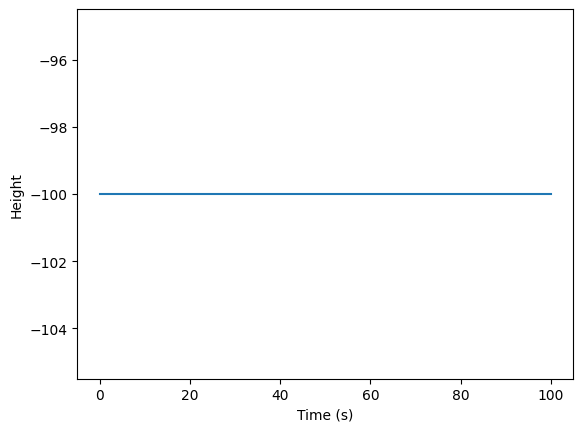

In [ ]:
t_max = 100
X = [x_0]
ts = np.arange(0, t_max+1)
for t in range(1, t_max+1):
    X.append(A @ X[t-1])
X = np.concat(X, axis=1)

plt.plot(ts, X[0, :])
plt.xlabel('Time (s)')
plt.ylabel('Height')
plt.show();

Script:
* If we run a quick simulation with out actions, then the quadcopter does not move.
* Again, we are assuming automatic compensation for gravity.

In [ ]:
B = np.array([[0], [1]])
B

array([[0],
       [1]])

Script:
* This $B$ maps the actions into acceleration changing the speed.
* For simplicity, this only updates the velocity.
* This doesn't matter if we were running a continuous simulation, but since we are simulating discrete time steps, we will see a lag of one step for the quadcopter to start moving.

## Quadcopter Cost Function

\begin{array}{rcl}
Q & = &
\begin{bmatrix}
q & 0 \\
0 & 0
\end{bmatrix} \\
R & = & \begin{bmatrix} r \end{bmatrix} \\
\end{array}

Script:
* Here is the setup for the cost function.
* The cost due to the state will simply be a penalty on just the position.
* The velocity will not be penalized.
* The little $q$ variable will be used to control the size of that penalty.
* Similarly, the little $r$ variable will be used to change the size of a penalty on action size.

In [ ]:
Q = np.array([[1, 0], [0, 1]])
R = np.array([[1]])

Script:
* I'll start with both $q$ and $r$ initialized to one as a baseline.

In [ ]:
K, S, E = control.dlqr(A, B, Q, R)
K

array([[0.42208244, 1.24392885]])

Script:
* We can quickly compute the $K$ matrix for optimal actions with the control module.
* The d in that function name dlqr stands for discrete.
* And lqr stands for linear quadratic regulator of course.
* Let's test out this $K$.

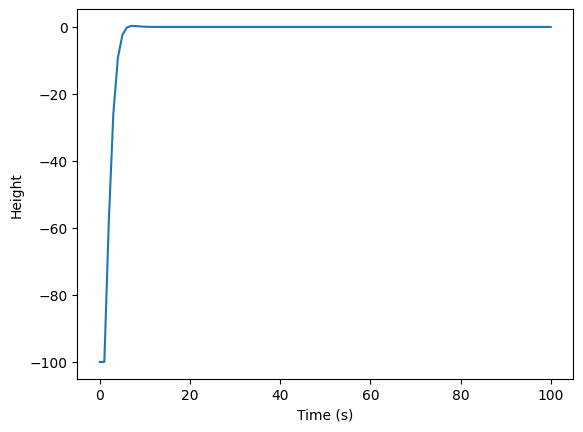

In [ ]:
def simulate_solved(A, B, K, x_0, t_max):
    X = [x_0]
    ts = np.arange(0, t_max+1)
    for t in range(1, t_max+1):
        X.append(A @ X[t-1] + B @ -K @ X[t-1])

    X = np.concat(X, axis=1)

    plt.plot(ts, X[0, :])
    plt.xlabel('Time (s)')
    plt.ylabel('Height')
    plt.show()

simulate_solved(A, B, K, x_0, t_max)

Script:
* If you are writing code for this yourself, watch out for the autocomplete making formula mistakes like dropping the minus sign.
* If we look at that trajectory, we see the quadcopter stay still for one time step, and then it shoots up pretty quickly.
* If you squint, you can see it overshoot slightly and then level out.
* Let's increase the penalty on being far from the stable point.

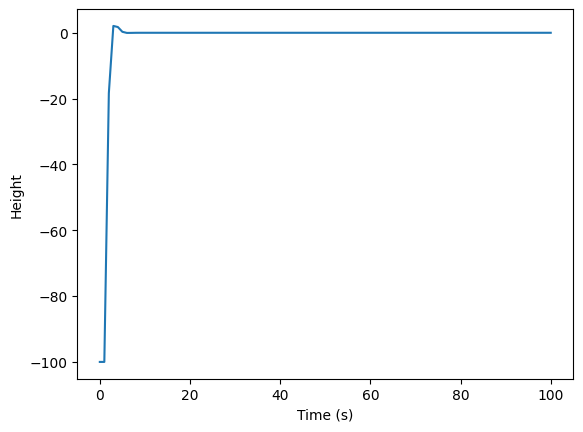

In [ ]:
def simulate_q(q):
    Q = np.array([[q, 0], [0, 0]])
    K, S, E = control.dlqr(A, B, Q, R)
    simulate_solved(A, B, K, x_0, t_max)

simulate_q(10)

Script:
* I increased the $q$ penalty to 10 and it overshot and then came back down more sharply than before.

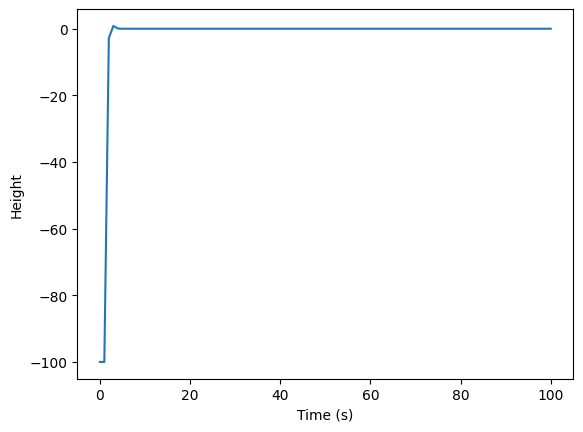

In [ ]:
simulate_q(100)

Script:
* Increasing the penalty is similar but overshoots a little less.
* Overshooting is penalized too of course.
* Let's change the action penalties now.

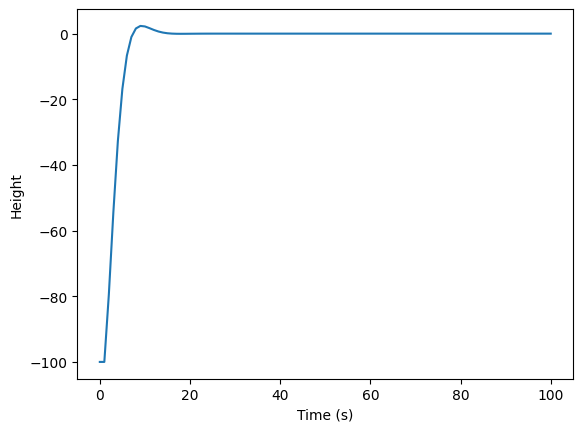

In [ ]:
def simulate_r(r):
    R = np.array([[r]])
    K, S, E = control.dlqr(A, B, Q, R)
    simulate_solved(A, B, K, x_0, t_max)

simulate_r(10)

Script:
* With a 10x action penalty, the quadcopter has a smoother looking flight.
* It still overshoots, and seems to settle down more smoothly.

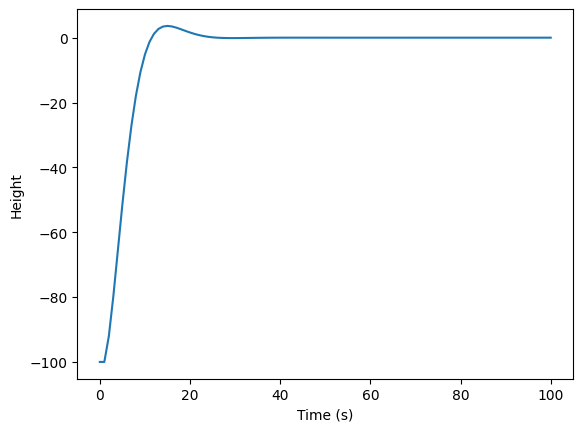

In [ ]:
simulate_r(100)

Script:
* With the 100x penalty, it takes longer to get up to speed and close to the set point.
* After that, it still overshoots and then levels out smoothly.
* High action penalties are definitely pushing for lighter acceleration.
* What if we make the action penalties really light?

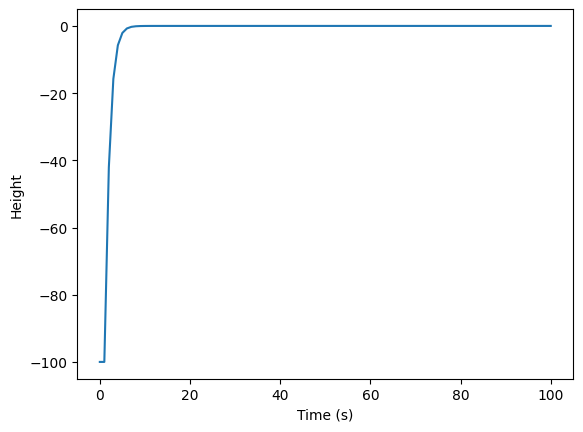

In [ ]:
simulate_r(0.1)

Script:
* With the lighter action penalty, the quadcopter rises pretty quickly and does not overshoot.

Script: (faculty on screen)
* We just saw that changing the cost function can significantly change the flight characteristics of a quadcopter.
* Heavier state penalties pushed for faster harder acceleration.
* Heavier action penalties pushed for smoother trajectories.
* Similar dynamics will apply to other problems, but the details will vary.